# Исследование рынка заведений общественного питания г. Москвы

Мы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами мы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможем ли мы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?
Подготовим исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.

**Цель исследования:** Проанализировать и рынок общепита Москвы, сделать презентацию для инвесторов.

**Содержание**
    
    
1. [Изучение и предобработка данных из файла](#open)
        
    
2. [Исследовательский анализ данных](#pred)


3. [Подготовка презентации](#portr)


4. [Общий вывод](#summary)

<a id="open"></a>
## 1. Изучение и предобработка данных из файла

**Описание данных:**

Таблица rest_data:
* id — идентификатор объекта;
* object_name — название объекта общественного питания;
* chain — сетевой ресторан;
* object_type — тип объекта общественного питания;
* address — адрес;
* number — количество посадочных мест.


In [1]:
# Импортируем библиотеки

import pandas as pd
import seaborn as sb
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from math import factorial
from scipy import stats as stats
import plotly.express as px
from plotly import graph_objects as go
import requests
from bs4 import BeautifulSoup
import requests, io, urllib.request

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_colwidth', 500)
pd.options.mode.chained_assignment = None

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Изучаем таблицу

path = '/datasets/rest_data.csv'

data = pd.read_csv(path, sep = ',' )
display(data.head(10))
data.tail(10)
data.sample(5)
data.describe().T
data.info()
# data['object_type'].unique()
# data['object_name'].unique()
# data['chain'].unique()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корпус 1",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",120


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Избавимся от неявных дубликатов и длинных значений

In [3]:
data['object_type'] = (data['object_type'].replace('кафетерий', 'кафе')
                       .replace('предприятие быстрого обслуживания', 'фастфуд')
                       .replace('магазин (отдел кулинарии)', 'отдел в магазине')
                      )

Преобразуем некорректные типы данных

In [4]:
data['chain'] = data['chain'].replace('нет', False).replace('да', True).astype('bool') 
data['number'] = data['number'].astype('Int16') 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  bool  
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  Int16 
dtypes: Int16(1), bool(1), int64(1), object(3)
memory usage: 540.3+ KB


### Вывод

Данные открыты и изучены. Названия колонок выглядят нормально. Пропусков в значениях не обнаружено. От неявных дубликатов избавились. Типы данных приведены к корректным.


<a id="pred"></a>
## 2. Исследовательский анализ данных

Выясним, какое соотношение видов объектов общественного питания по количеству


,object_type,cnt,total,share
0,бар,856,15366,0.06
1,буфет,585,15366,0.04
2,закусочная,360,15366,0.02
3,кафе,6497,15366,0.42
4,отдел в магазине,273,15366,0.02
5,ресторан,2285,15366,0.15
6,столовая,2587,15366,0.17
7,фастфуд,1923,15366,0.13


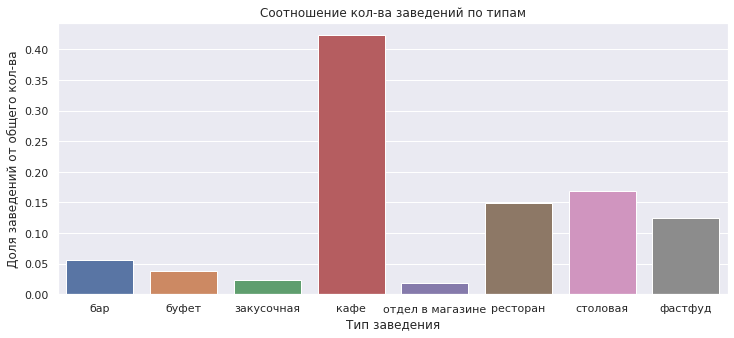

In [10]:
# Сгруппируем таблицу по типам общепита
tip_op = data.pivot_table(index='object_type', values='id', aggfunc='count').reset_index()
tip_op.columns = ['object_type', 'cnt']
tip_op['total'] = tip_op['cnt'].sum()
tip_op['share'] = tip_op['cnt']/tip_op['total']
tip_op=tip_op.sort_values('object_type')
display(tip_op)

# Построим график
bar = sb.barplot(y='share',x='object_type',  data=tip_op.sort_values('object_type'))
sb.set(rc = {'figure.figsize':(12,5)})
bar.set(xlabel='Тип заведения', ylabel='Доля заведений от общего кол-ва', title='Соотношение кол-ва заведений по типам')
plt.show()

По графику можно увидеть, что большинство заведений относятся к типу кафе, затем идут столовые, рестораны и фастфуд.

Исследуем соотношение сетевых и несетевых заведений по количеству.

,chain,cnt,total,share
0,False,12398,15366,0.81
1,True,2968,15366,0.19


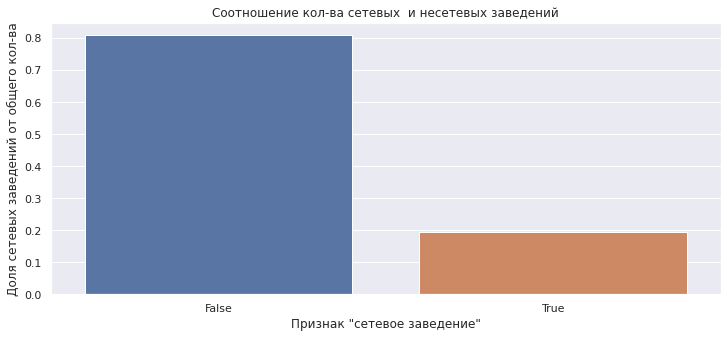

In [6]:
# Сгруппируем таблицу по признаку "сетевое"
tip_chain = data.pivot_table(index='chain', values='id', aggfunc='count').reset_index()
tip_chain.columns = ['chain', 'cnt']
tip_chain['total'] = tip_chain['cnt'].sum()
tip_chain['share'] = tip_chain['cnt']/tip_chain['total']
display(tip_chain.sort_values('chain'))

# Построим график 
bar = sb.barplot(y='share',x='chain',  data=tip_chain.sort_values('chain'))
sb.set(rc = {'figure.figsize':(12,5)})
bar.set(xlabel='Признак "сетевое заведение"', ylabel='Доля сетевых заведений от общего кол-ва', title='Соотношение кол-ва сетевых  и несетевых заведений')
plt.show()

80% заведений - не сетевые

Посмотрим для какого вида объекта общественного питания характерно сетевое распространение.

,nochain,chain,total,share
object_type,,,,
столовая,2584,3,2587,0.12
буфет,574,11,585,1.88
бар,819,37,856,4.32
закусочная,304,56,360,15.56
кафе,5049,1448,6497,22.29
ресторан,1741,544,2285,23.81
отдел в магазине,195,78,273,28.57
фастфуд,1132,791,1923,41.13


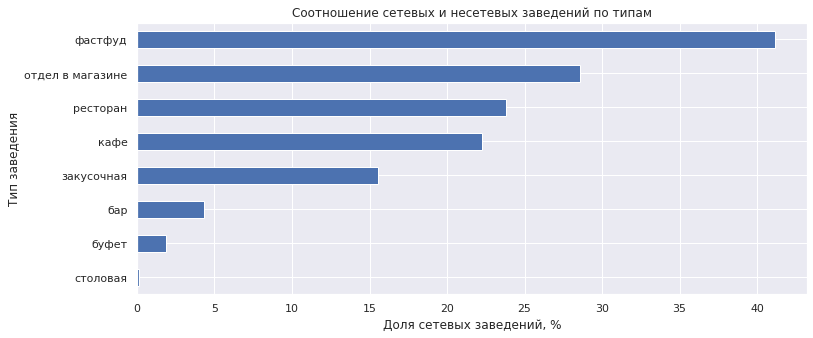

In [7]:
# Сгруппируем таблицу по типам общепита с разбвкой по признаку "сетевое".
tip_op_chain = data.pivot_table(index='object_type', columns = 'chain',values='id', aggfunc='nunique')
tip_op_chain
tip_op_chain.columns = [ 'nochain', 'chain']
tip_op_chain['total'] = tip_op_chain['chain'] + tip_op_chain['nochain']
tip_op_chain['share'] = (tip_op_chain['chain'] / tip_op_chain['total']) * 100
tip_op_chain=tip_op_chain.sort_values('share')
display(tip_op_chain.sort_values('share'))

# Построим график 
graph = tip_op_chain['share'].plot(kind = 'barh', stacked = True)
sb.set(rc = {'figure.figsize':(12,5)})
graph.set(xlabel='Доля сетевых заведений, %', ylabel='Тип заведения', title='Соотношение сетевых и несетевых заведений по типам')
plt.show()

Сетевое распространение наиболее характерно для фастфуда, магазинных кулинарий, ресторанов и кафе.

Посмотрим, что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест.

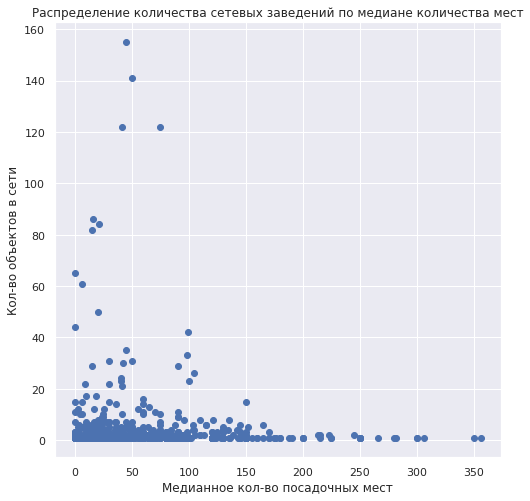

In [8]:
chain_zav = data[data['chain']==True].groupby('object_name').agg({'object_name':'count', 'number':'median'})
chain_zav.columns = ['objects', 'med_number']
plt.figure(figsize=(8,8))
plt.scatter(chain_zav['med_number'], chain_zav['objects'])
plt.xlabel('Медианное кол-во посадочных мест')
plt.ylabel('Кол-во объектов в сети')
plt.title('Распределение количества сетевых заведений по медиане количества мест')

plt.show()

# np.percentile(chain_zav['med_number'], 95)

Из графика видно, что в сетевых заведениях - мало заведений с большим количеством посадочных мест. В 95% сетей не больше 155 посадочных мест.

Для каждого вида объекта общественного питания опишем среднее количество посадочных мест. Посмотрим, какой вид предоставляет в среднем самое большое количество посадочных мест.

In [13]:
seats_object = data.pivot_table(index='object_type', values='number', aggfunc='median').sort_values(by='number', ascending=False).reset_index()
seats_object.columns=['Тип заведений', 'Среднее кол-во мест']
print('Топ-5 типов объектов по количеству посадочных мест:\n\n', seats_object.head(5))

fig = px.bar(seats_object, x='Тип заведений', y='Среднее кол-во мест',  text = 'Среднее кол-во мест', color='Тип заведений', width = 900, height = 550)
for trace in fig.data:
    trace.name = trace.name.split('=')[0]
fig.update_layout(title='Среднее кол-во посадочных мест по типам заведений')
fig.show()


Топ-5 типов объектов по количеству посадочных мест:

   Тип заведений  Среднее кол-во мест
0      столовая               103.00
1      ресторан                80.00
2           бар                35.00
3         буфет                32.00
4          кафе                30.00


Наибольшее количество посадочных мест у столовых. В среднем 103 места.

Выделим в отдельный столбец информацию об улице из столбца address

In [14]:
street_type = ['улица', 'бульвар', 'проспект', 'переулок', 'шоссе', 'проезд', 'набережная', 'площадь', 'аллея', 'линия', 'квартал', 'мост', 'тупик', 'просека']
def street_parser (address):
    for address_part in address.split(', '):
        for types in street_type:
            if address_part.lower().find(types)!= -1:
                return address_part

data['street'] = data['address'].apply(street_parser)

data_streets = data[~(data['street'].isnull())]

display(data_streets.head(5))

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


Построим график топ-10 улиц по количеству объектов общественного питания. Воспользуемся внешней информацией и ответим на вопрос — в каких районах Москвы находятся эти улицы.

In [15]:
# Подключим внешние данные
spreadsheet_id = '1CPDYDGjKCb6jGoQt9KR5WOvTspK-dHS3NUrVeqsyqJs'
filename= 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
# filename
r = requests.get(filename)
district = pd.read_csv(io.BytesIO(r.content))
display(district)

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


In [17]:
top_streets = data_streets.groupby('street', as_index=False).agg({'object_name':'count'})
top_streets.columns = ['street', 'objects']
top_streets = top_streets.sort_values(by='objects', ascending = False)
top10_streets = top_streets.head(10)
print('Топ-10 улиц с наибольшим количеством заведений:\n', top10_streets)

fig = px.bar(top10_streets, x='street', y='objects', 
             color='street', width = 900, height = 550, text='objects')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title='Топ-10 улиц с наибольшим количеством заведений',
    xaxis_title="Улица",
    yaxis_title="Количество заведений")
for trace in fig.data:
    trace.name = trace.name.split('=')[0]
fig.show()


top10_streets_merged = top10_streets.merge(district[['streetname', 'okrug', 'area']], left_on='street', right_on='streetname')
streets = pd.DataFrame(data=top10_streets_merged['street'].unique(), columns=['street'])

def areas(row, data):
    result = data[data['street']==row['street']]['area'].to_list()
    return result
top10_streets['areas'] = top10_streets.apply(areas, args=[top10_streets_merged], axis=1)
print('\n')
for street, areas in zip(top10_streets['street'], top10_streets['areas']):
    print('{} находится в:'.format(street))   
    for area in areas:
        numeric=1
        print('-', area)
    print('')    

Топ-10 улиц с наибольшим количеством заведений:
                       street  objects
1426           проспект Мира      204
1014       Профсоюзная улица      183
686   Ленинградский проспект      173
997   Пресненская набережная      167
399         Варшавское шоссе      165
689       Ленинский проспект      148
1422    проспект Вернадского      132
676     Кутузовский проспект      114
599          Каширское шоссе      112
606     Кировоградская улица      110




проспект Мира находится в:
- Алексеевский район
- Ярославский Район
- Район Марьина роща
- Останкинский район
- Район Ростокино
- Район Свиблово
- Мещанский район

Профсоюзная улица находится в:
- Академический район
- Район Черемушки
- Район Ясенево
- Район Коньково
- Обручевский район
- Район Теплый Стан

Ленинградский проспект находится в:
- Район Аэропорт
- Район Беговой
- Хорошевский район
- Район Сокол

Пресненская набережная находится в:
- Пресненский район

Варшавское шоссе находится в:
- Район Чертаново Центральное
- Район Чертаново Северное
- Район Чертаново Южное
- Донской район
- Район Нагатино-Садовники
- Нагорный район
- Район Северное Бутово
- Район Южное Бутово

Ленинский проспект находится в:
- Район Проспект Вернадского
- Район Тропарево-Никулино
- Донской район
- Район Гагаринский
- Ломоносовский район
- Обручевский район
- Район Теплый Стан
- Район Якиманка

проспект Вернадского находится в:
- Район Проспект Вернадского
- Район Раменки
- Район Тропарево-Никулино
-

Найдем число улиц с одним объектом общественного питания. Воспользуемся внешней информацией и ответим на вопрос — в каких районах Москвы находятся эти улицы.

In [18]:
streets_with_1_object = top_streets[top_streets['objects']==1]
print('Всего улиц с 1 объектом общественного питания: {}, что составляет {:.1%} от всего кол-ва улиц с объектами общественного питания'\
      .format(len(streets_with_1_object), (len(streets_with_1_object)/len(top_streets))))

streets_with_1_object_merged = streets_with_1_object.merge(district[['streetname', 'okrug', 'area']], left_on='street', right_on='streetname')

def areas(row, data):
    result = data[data['street']==row['street']]['area'].to_list()
    return result
streets_with_1_object['areas'] = streets_with_1_object.apply(areas, args=[streets_with_1_object_merged], axis=1)
print('\n')

print('Районы, в которых находятся улицы с 1 объектом общественного питания:')
for area in streets_with_1_object_merged['area'].sort_values().unique():
    print('-', area)

Всего улиц с 1 объектом общественного питания: 551, что составляет 28.9% от всего кол-ва улиц с объектами общественного питания


Районы, в которых находятся улицы с 1 объектом общественного питания:
- Алексеевский район
- Алтуфьевский район
- Бабушкинский район
- Басманный район
- Бескудниковский Район
- Бутырский район
- Войковский Район
- Головинский район
- Даниловский район
- Дмитровский район
- Донской район
- Красносельский район
- Лосиноостровский район
- Мещанский район
- Можайский Район
- Молжаниновский район
- Нагорный район
- Нижегородский район
- Обручевский район
- Останкинский район
- Панфиловский район
- Пресненский район
- Район Арбат
- Район Аэропорт
- Район Беговой
- Район Бирюлево Восточное
- Район Богородское
- Район Внуково
- Район Восточное Измайлово
- Район Восточный
- Район Выхино-Жулебино
- Район Гагаринский
- Район Гольяново
- Район Дорогомилово
- Район Замоскворечье
- Район Западное Дегунино
- Район Зюзино
- Район Ивановское
- Район Измайлово
- Район Коньков

Посмотрим на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Выявим закономерности.

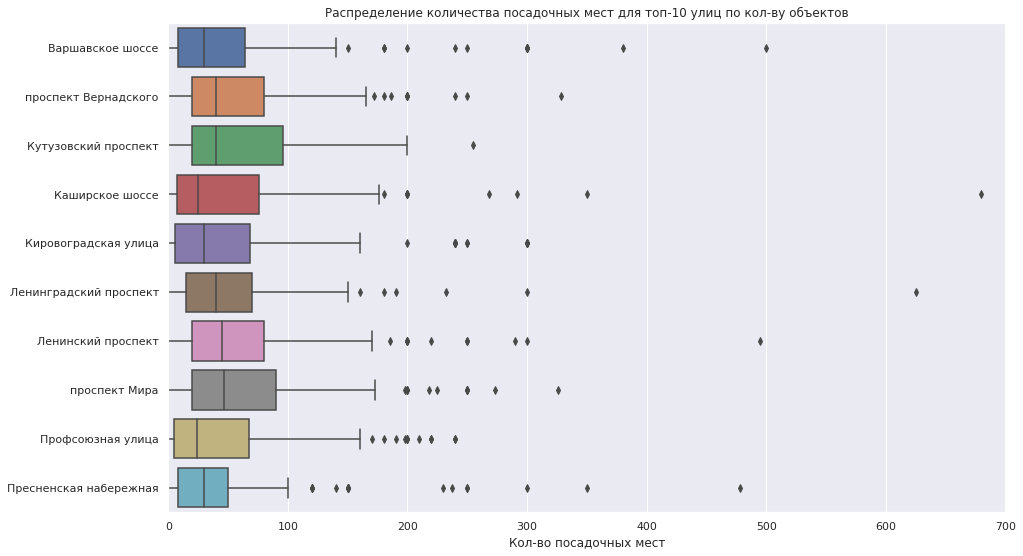

Среднее кол-во посадочных мест в заведениях на топ-10 улицах по количеству объектов: 38.5
Среднее кол-во посадочных мест в заведениях на остальных улицах по количеству объектов: 40.0

Проверим, значима ли статистически разница между кол-вами посадочных мест в заведениях на топ-10 улицах и остальных.
Нулевой гипотезой будет гипотеза о равенстве количества посадочных мест на топ-10 улицах по количеству объектов и на остальных улицах.
P-value: 0.3868435747276795
Не отвергаем нулевую гипотезу. Разницы между количествами посадочных мест не выявлено.


In [19]:
top10_streets_list = top10_streets['street'].to_list()
top10_streets_data = data.query('street in @top10_streets_list')

top10_streets_data['number'].median()
data['number'].median()
plt.figure(figsize=(15,9))
plt.xlim(0,700)
sb.boxplot(data=top10_streets_data, x='number', y='street')
plt.title('Распределение количества посадочных мест для топ-10 улиц по кол-ву объектов')
plt.ylabel('')
plt.xlabel('Кол-во посадочных мест')
plt.show()

print('Среднее кол-во посадочных мест в заведениях на топ-10 улицах по количеству объектов: {}'.format(top10_streets_data['number'].median()))
print('Среднее кол-во посадочных мест в заведениях на остальных улицах по количеству объектов: {}'\
.format(data.query('street not in @top10_streets_list')['number'].median()))

print('\nПроверим, значима ли статистически разница между кол-вами посадочных мест в заведениях на топ-10 улицах и остальных.')

print('Нулевой гипотезой будет гипотеза о равенстве количества посадочных мест на топ-10 улицах по количеству объектов и на остальных улицах.')
alpha=0.05

results = stats.ttest_ind(data.query('street not in @top10_streets_list')['number'],
                            top10_streets_data['number'])
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, разница между количествами посадочных мест статистически значима.')
else:
    print('Не отвергаем нулевую гипотезу. Разницы между количествами посадочных мест не выявлено.')

<a id="portr"></a>
## 3. Подготовка презентации

Презентация: https://drive.google.com/file/d/1ujAPPvtiHPxnQnS07E-iX1tlZ4CX0lg6/view?usp=sharing

<a id="summary"></a>
## 4. Общий вывод

Были открыты и изучены данные общепита Москвы.

* Проведена предобработка данных, заменены неявные дубликаты.<br>
* Типы полей были изменены в соответствии с данными в них и исходя из целей экономии памяти.<br>

Проведен исследовательский анализ данных:

* Мы выяснили, что наибольшее количество типов объектов общественного притания составляют кафе (более 40%), затем идут столовые, рестораны и фастфуд.

* Только 20% от общего количества заведений - сетевые.

* Сетевое распространение наиболее характерно для фастфуда, магазинных кулинарий, ресторанов и кафе..

* В 95% сетей не больше  155 посадочных мест.

* Среднее количество посадочных мест по типам объектов общественного питания: столовая - 103, ресторан - 80, бар - 35, буфет - 32, кафе - 30. Столовая лидирует.

* Топ-10 улиц с наибольшим количеством заведений:

  1. проспект Мира
  2. Профсоюзная улица
  3. Ленинградский проспект
  4. Пресненская набережная
  5. Варшавское шоссе
  6. Ленинский проспект
  7. проспект Вернадского
  8. Кутузовский проспект
  9. Каширское шоссе
  10. Кировоградская улица


* Всего улиц с одним объектом общественного питания: 551, что составляет 28.9% от всего кол-ва улиц с объектами общественного питания в Москве. 

* Среднее кол-во посадочных мест в заведениях на топ-10 улицах по количеству объектов: 38.5 Среднее кол-во посадочных мест в заведениях на остальных улицах по количеству объектов: 40. Статистически значимой разницы между количествами посадочных мест на топ-10 и остальных улицах не выявлено.

Рекомендации:

Наиболее популярный тип заведений на рынке - кафе со средним количеством посадочных мест на 30 персон. Порекомендуем именно этот тип общепита. Однако, если стартовый капитал невысок, стоит рассмотреть и столовую на 103 посадочных места. 
Кафе лучше разместить на одной из топ-10 улиц, вероятно, проходимость здесь самая высокая, но следует также учесть конкуренцию.